In [119]:
from transformers import PretrainedConfig
import torch
import numpy as np
import math
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
# from transformers.models.llama.configuration_llama import LlamaConfig
import seaborn as sns

# positional embedding

In [120]:
def _compute_default_rope_parameters(
    config: Optional[PretrainedConfig] = None,
    device: Optional["torch.device"] = None,
    **rope_kwargs,
) -> Tuple["torch.Tensor", float]:
    """
    Computes the inverse frequencies according to the original RoPE implementation
    Args:
        config ([`~transformers.PretrainedConfig`]):
            The model configuration.
        device (`torch.device`):
            The device to use for initialization of the inverse frequencies.
        rope_kwargs (`Dict`, *optional*):
            BC compatibility with the previous RoPE class instantiation, will be removed in v4.45.
    Returns:
        Tuple of (`torch.Tensor`, `float`), containing the inverse frequencies for the RoPE embeddings and the
        post-processing scaling factor applied to the computed cos/sin (unused in this type of RoPE).
    """
    if config is not None and len(rope_kwargs) > 0:
        raise ValueError(
            "Unexpected arguments: `**rope_kwargs` and `config` are mutually exclusive in "
            f"`_compute_default_rope_parameters`, got `rope_kwargs`={rope_kwargs} and `config`={config}"
        )
    if len(rope_kwargs) > 0:
        base = rope_kwargs["base"]
        dim = rope_kwargs["dim"]
    elif config is not None:
        base = config.base
        partial_rotary_factor = config.partial_rotary_factor if hasattr(config, "partial_rotary_factor") else 1.0
        head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        dim = int(head_dim * partial_rotary_factor)

    attention_factor = 1.0  # Unused in this type of RoPE

    # Compute the inverse frequencies
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.int64).float().to(device) / dim))
    return inv_freq, attention_factor

In [121]:
def _compute_2d_rope_parameters(
    config: Optional[PretrainedConfig] = None,
    device: Optional["torch.device"] = None,
    **rope_kwargs,
) -> Tuple["torch.Tensor", float]:
    """
    Computes the inverse frequencies according to the original RoPE implementation
    Args:
        config ([`~transformers.PretrainedConfig`]):
            The model configuration.
        device (`torch.device`):
            The device to use for initialization of the inverse frequencies.
        rope_kwargs (`Dict`, *optional*):
            BC compatibility with the previous RoPE class instantiation, will be removed in v4.45.
    Returns:
        Tuple of (`torch.Tensor`, `float`), containing the inverse frequencies for the RoPE embeddings and the
        post-processing scaling factor applied to the computed cos/sin (unused in this type of RoPE).
    """
    if config is not None and len(rope_kwargs) > 0:
        raise ValueError(
            "Unexpected arguments: `**rope_kwargs` and `config` are mutually exclusive in "
            f"`_compute_default_rope_parameters`, got `rope_kwargs`={rope_kwargs} and `config`={config}"
        )
    if len(rope_kwargs) > 0:
        base = rope_kwargs["base"]
        dim = rope_kwargs["dim"]
    elif config is not None:
        base = config.base
        partial_rotary_factor = config.partial_rotary_factor if hasattr(config, "partial_rotary_factor") else 1.0
        head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        dim = int(head_dim * partial_rotary_factor)

    attention_factor = 1.0  # Unused in this type of RoPE

    # Compute the inverse frequencies
    inv_freq = 1.0 / (base ** (2 * (torch.div(torch.arange(0, dim, 2, device=device), 2, rounding_mode='floor') / dim)))
    return inv_freq, attention_factor

In [122]:
def _compute_interleaved_rope_parameters(
    config: Optional[PretrainedConfig] = None,
    device: Optional["torch.device"] = None,
    **rope_kwargs,
) -> Tuple["torch.Tensor", float]:
    """
    Computes the inverse frequencies according to the original RoPE implementation
    Args:
        config ([`~transformers.PretrainedConfig`]):
            The model configuration.
        device (`torch.device`):
            The device to use for initialization of the inverse frequencies.
        rope_kwargs (`Dict`, *optional*):
            BC compatibility with the previous RoPE class instantiation, will be removed in v4.45.
    Returns:
        Tuple of (`torch.Tensor`, `float`), containing the inverse frequencies for the RoPE embeddings and the
        post-processing scaling factor applied to the computed cos/sin (unused in this type of RoPE).
    """
    if config is not None and len(rope_kwargs) > 0:
        raise ValueError(
            "Unexpected arguments: `**rope_kwargs` and `config` are mutually exclusive in "
            f"`_compute_default_rope_parameters`, got `rope_kwargs`={rope_kwargs} and `config`={config}"
        )
    if len(rope_kwargs) > 0:
        base = rope_kwargs["base"]
        dim = rope_kwargs["dim"]
    elif config is not None:
        base = config.base
        partial_rotary_factor = config.partial_rotary_factor if hasattr(config, "partial_rotary_factor") else 1.0
        head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        dim = int(head_dim * partial_rotary_factor)
        rate = getattr(config, "rate", 4)
    
    # Original inv_freq
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, device=device).float() / dim))
    
    # 2D inv_freq
    inv_freq_2d = 1.0 / (base ** (2 * (torch.div(torch.arange(0, dim, 2, device=device), 2, rounding_mode='floor') / dim)))
    
    # Interleave frequencies
    inv_freq_interleaved = inv_freq.clone()
    inv_freq_interleaved[rate - 2 :: rate] = inv_freq_2d[rate - 2 :: rate]
    inv_freq_interleaved[rate - 1 :: rate] = inv_freq_2d[rate - 1 :: rate]
    
    attention_factor = 1.0
    return inv_freq_interleaved, attention_factor

In [123]:
# RoPE function registry
ROPE_INIT_FUNCTIONS = {
    "default": _compute_default_rope_parameters,
    "2d": _compute_2d_rope_parameters,
    "interleaved": _compute_interleaved_rope_parameters,
}


In [138]:
# Define a simple Config class for testing purposes
SEQ_LEN = 512
DIMENSION = 5120
LINE_LENGTH = 32
BASE = 10000
BATCH_SIZE = 1

class Config:
    def __init__(self, base=BASE, head_dim=DIMENSION, rate=4, line_length=LINE_LENGTH, rope_type="default", max_position_embeddings=2048):
        self.base = base
        self.head_dim = head_dim
        self.rate = rate
        self.line_length = line_length
        self.rope_type = rope_type
        self.max_position_embeddings = max_position_embeddings

        # unnecssary
        self.partial_rotary_factor = 1
        self.hidden_size = DIMENSION
        self.num_attention_heads = 1
        self.rope_scaling = None



In [262]:
# Modified LlamaRotaryEmbedding class
class LlamaRotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim=None,
        max_position_embeddings=2048,
        base=10000,
        device=None,
        scaling_factor=1.0,
        rope_type="default",
        config: Optional[Config] = None,
        **kwargs,
    ):
        super().__init__()
        self.rope_kwargs = {}
        if config is None:
            self.rope_kwargs = {
                "rope_type": rope_type,
                "factor": scaling_factor,
                "dim": dim,
                "base": base,
                "max_position_embeddings": max_position_embeddings,
            }
            self.rope_type = rope_type
            self.max_seq_len_cached = max_position_embeddings
            self.original_max_seq_len = max_position_embeddings
        else:
            self.rope_type = config.rope_type
            self.max_seq_len_cached = config.max_position_embeddings
            self.original_max_seq_len = config.max_position_embeddings

        self.config = config
        self.rope_init_fn = ROPE_INIT_FUNCTIONS[self.rope_type]

        # Include any additional arguments
        self.rope_kwargs.update(kwargs)

        inv_freq, self.attention_scaling = self.rope_init_fn(self.config, device, **self.rope_kwargs)
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        self.original_inv_freq = self.inv_freq

        # For 2D RoPE and other variants requiring additional parameters
        self.line_length = config.line_length
        self.rate = config.rate

    def _dynamic_frequency_update(self, position_ids, device):
        seq_len = torch.max(position_ids) + 1
        if seq_len > self.max_seq_len_cached:
            inv_freq, self.attention_scaling = self.rope_init_fn(
                self.config, device, seq_len=seq_len, **self.rope_kwargs
            )
            self.register_buffer("inv_freq", inv_freq, persistent=False)
            self.max_seq_len_cached = seq_len

        if seq_len < self.original_max_seq_len and self.max_seq_len_cached > self.original_max_seq_len:
            self.register_buffer("inv_freq", self.original_inv_freq, persistent=False)
            self.max_seq_len_cached = self.original_max_seq_len

    @torch.no_grad()
    def forward(self, x, position_ids):
        if "dynamic" in self.rope_type:
            self._dynamic_frequency_update(position_ids, device=x.device)

        # position_ids (batch_size, seq_len)
        # inv_freq (dim // 2)
        device_type = x.device.type
        device_type = device_type if device_type == "cuda" else "cpu"
        # position_ids is a tensor of shape (batch_size, seq_len)
        with torch.autocast(device_type=device_type, enabled=False):
            if self.rope_type == "2d":
                print('2d')
                line_length = self.line_length
                # (batch_size, dim, seq_len)
                position_ids_expanded = position_ids[:, None, :].float().repeat(1, self.inv_freq.shape[0], 1)
                position_ids_expanded[:, 0::2, :] = position_ids_expanded[:, 0::2, :] % line_length
                position_ids_expanded[:, 1::2, :] = position_ids_expanded[:, 1::2, :] // line_length
            elif self.rope_type == "interleaved":
                print('interleaved')
                position_ids_expanded_2d = position_ids[:, None, :].float().repeat(1, self.inv_freq.shape[0], 1)
                position_ids_expanded_2d[:, 0::2, :] = position_ids_expanded_2d[:, 0::2, :] % self.line_length
                position_ids_expanded_2d[:, 1::2, :] = position_ids_expanded_2d[:, 1::2, :] // self.line_length

                position_ids_expanded = position_ids[:, None, :].float().repeat(1, self.inv_freq.shape[0], 1)
                position_ids_expanded[:, self.rate-2::self.rate, :] = position_ids_expanded_2d[:, self.rate-2::self.rate, :]
                position_ids_expanded[:, self.rate-1::self.rate, :] = position_ids_expanded_2d[:, self.rate-2::self.rate, :]
            else:
                print('default')
                position_ids_expanded = position_ids[:, None, :].float().repeat(1, self.inv_freq.shape[0], 1)
   
            inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids_expanded.shape[0], -1, position_ids_expanded.shape[2])
            freqs = (inv_freq_expanded.float() * position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
        
            cos = emb.cos()
            sin = emb.sin()
            cos = cos * self.attention_scaling
            sin = sin * self.attention_scaling

        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


# TEST utils

In [263]:

def run_test(rope_type):
    config = Config()
    config.max_position_embeddings = 2048
    config.line_length = 32
    config.rate = 4
    config.rope_type = rope_type
    config.head_dim = 5120
    config.line_length = 32

    X = torch.ones((BATCH_SIZE, DIMENSION, SEQ_LEN))
    position_ids = torch.arange(SEQ_LEN).unsqueeze(0).repeat(BATCH_SIZE, 1)

    embedding = LlamaRotaryEmbedding(config=config)(X, position_ids)

    # apply_rotation
    cos, sin = embedding
    cos = cos.squeeze(0).transpose(0, 1)
    sin = sin.squeeze(0).transpose(0, 1)

    X = X.squeeze(0)
    X_rotated = torch.zeros_like(X)
    X_rotated[::2], X_rotated[1::2] = -X[1::2], X[::2]

    X_rope = (X * cos) + (X_rotated * sin)
    return X_rope

In [264]:
# Calculate the cosine similarity
def cosine_similarity(X1, X2):
    dot = np.dot(X1.T, X2)
    norm_X1 = np.linalg.norm(X1, axis=0, keepdims=True)
    norm_X2 = np.linalg.norm(X2, axis=0, keepdims=True)
    return dot / (norm_X1.T @ norm_X2)

In [265]:
def plot_spatial_similarity(m, w, h, similarity_matrix, line_length):
    plt.figure(figsize=(8, 6))

    map = np.zeros((h,w))
    center = m + w//2 + h//2*line_length
    for j in range(h):
        for i in range(w):
            realpos = m + j*line_length + i
            val = similarity_matrix[center,realpos]
            map[h-j-1,i] = val
            plt.text(i, h-j-1, f'{val:.2f}', ha='center', va='center', color="black")

    # Set the range from 0 to 1
    plt.imshow(map, cmap='viridis', origin='lower', vmax=1, vmin=0)
    # Set x ticks and y ticks
    plt.xticks(np.arange(0, w, 1), np.arange(0, w, 1)-w//2)
    plt.yticks(np.arange(0, h, 1), np.arange(h, 0, -1)-h//2-1)
    plt.colorbar(label='Similarity')
    plt.show()

In [266]:
def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='viridis', origin='lower')
    plt.colorbar(label='Similarity')
    plt.title('Cosine Similarity Matrix')
    plt.show()

default


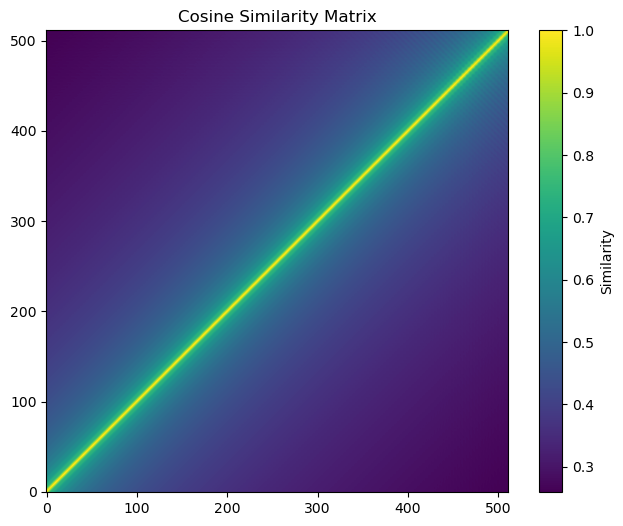

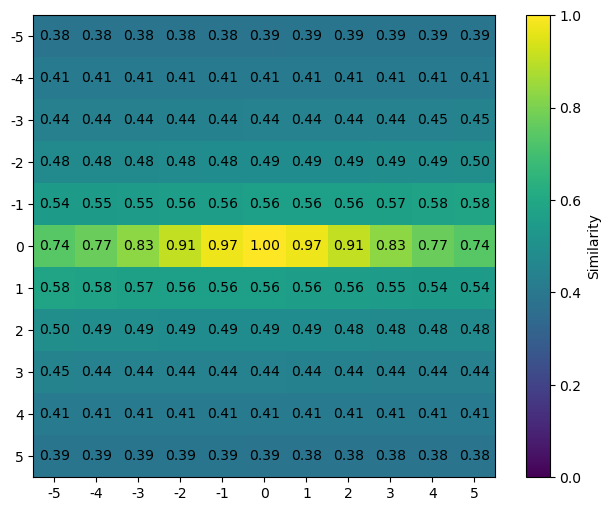

In [267]:
X_rope = run_test("default")
similarity_matrix = cosine_similarity(X_rope, X_rope)
plot_similarity_matrix(similarity_matrix)
plot_spatial_similarity(3, 11, 11, similarity_matrix, LINE_LENGTH)


2d


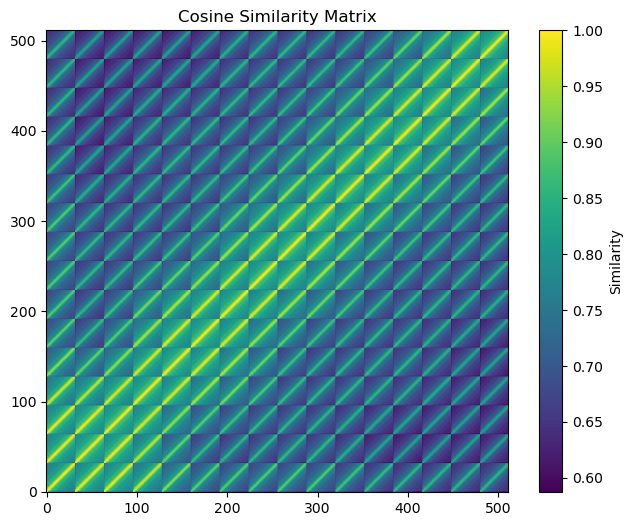

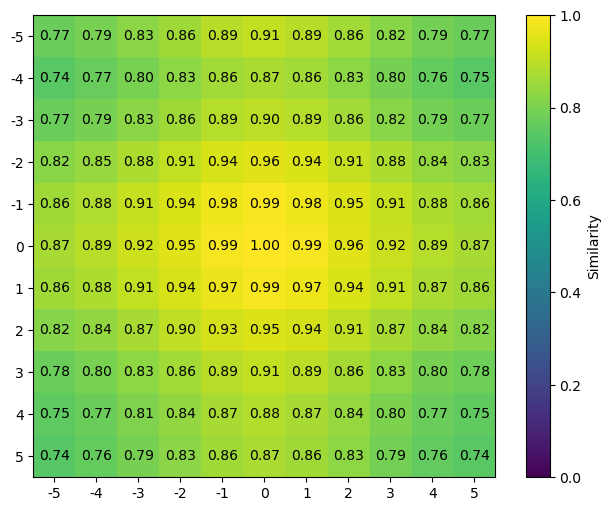

In [268]:
X_rope = run_test("2d")
similarity_matrix = cosine_similarity(X_rope, X_rope)
plot_similarity_matrix(similarity_matrix)
plot_spatial_similarity(3, 11, 11, similarity_matrix, LINE_LENGTH)

interleaved


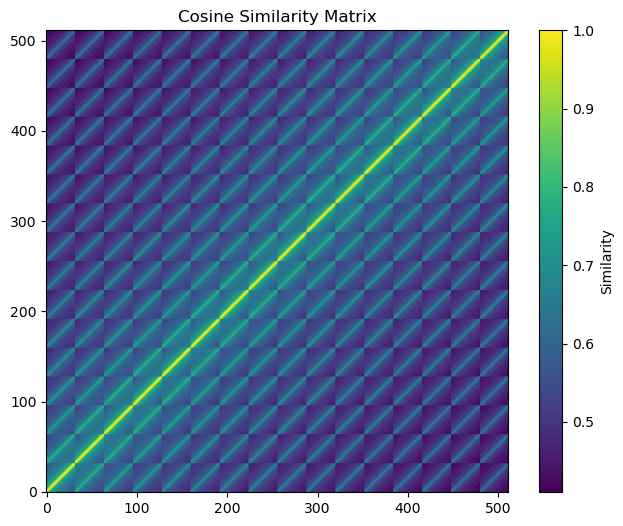

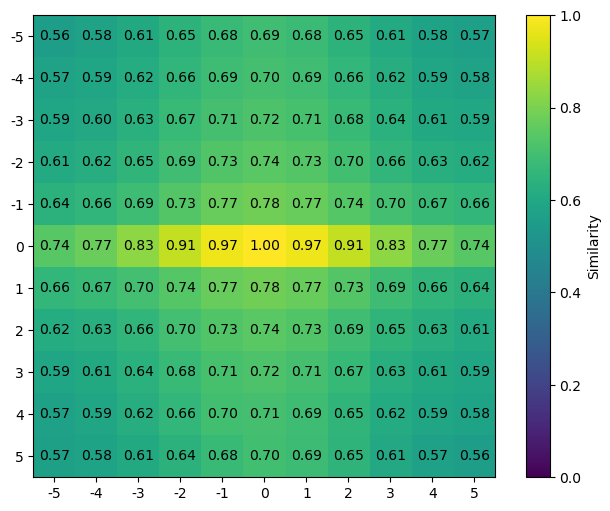

In [269]:
X_rope = run_test("interleaved")
similarity_matrix = cosine_similarity(X_rope, X_rope)
plot_similarity_matrix(similarity_matrix)
plot_spatial_similarity(3, 11, 11, similarity_matrix, LINE_LENGTH)